# NASA Battery Degradation Preprocessing
This notebook loads MATLAB `.mat` files from the NASA Prognostics Center of Excellence dataset (`B0005.mat` to `B0056.mat`), extracts battery degradation curves, normalizes capacity, visualizes degradation trends, and saves the processed data.

In [84]:
# --- 1. Setup ---
import os
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [85]:
# --- 2. Define File Paths ---
# Assuming your dataset is in a folder named 'data/nasa_battery'
base_dir = '../data/raw/NASA/'
battery_ids = [f'B{str(i).zfill(4)}.mat' for i in range(5, 57)]  # B0005.mat to B0056.mat

available_files = [f for f in battery_ids if os.path.exists(os.path.join(base_dir, f))]

print(f"Available files ({len(available_files)}):")
print(available_files)

Available files (34):
['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat', 'B0025.mat', 'B0026.mat', 'B0027.mat', 'B0028.mat', 'B0029.mat', 'B0030.mat', 'B0031.mat', 'B0032.mat', 'B0033.mat', 'B0034.mat', 'B0036.mat', 'B0038.mat', 'B0039.mat', 'B0040.mat', 'B0041.mat', 'B0042.mat', 'B0043.mat', 'B0044.mat', 'B0045.mat', 'B0046.mat', 'B0047.mat', 'B0048.mat', 'B0049.mat', 'B0050.mat', 'B0051.mat', 'B0052.mat', 'B0053.mat', 'B0054.mat', 'B0055.mat', 'B0056.mat']


In [86]:
# --- 3. Function to Extract Battery Data ---
def load_battery_data(filepath):
    try:
        mat = scipy.io.loadmat(filepath)
        print(mat.keys())  # Print keys
        
        # Get the battery ID key (e.g., 'B0005')
        battery_key = [key for key in mat.keys() if not key.startswith('__')][0]
        battery_data = mat[battery_key][0, 0]  # Access struct
        print(f"Fields in {battery_key}: {battery_data.dtype.names}")
        
        all_cycles = []

        # Access 'cycle' field (array of structs)
        cycles = battery_data['cycle'][0]
        print(f"Number of cycles: {len(cycles)}")
        
        for cycle_idx, cycle in enumerate(cycles):
            # Inspect cycle structure
            print(f"Cycle {cycle_idx} fields: {cycle.dtype.names}")
            
            # Extract cycle type
            cycle_type = cycle['type'][0]
            if isinstance(cycle_type, np.bytes_):
                cycle_type = cycle_type.decode('utf-8')
            print(f"Cycle {cycle_idx} type: {cycle_type}")
            
            if cycle_type.lower() == 'discharge':  # Process only discharge cycles
                cycle_data = cycle['data'][0]  # Access data struct
                print(f"Cycle {cycle_idx} data fields: {cycle_data.dtype.names}")
                
                # Extract measurements
                voltage = cycle_data['Voltage_measured'][0].flatten()
                current = cycle_data['Current_measured'][0].flatten()
                temp = cycle_data['Temperature_measured'][0].flatten()
                time = cycle_data['Time'][0].flatten()
                
                # Extract capacity with dynamic indexing
                capacity_raw = cycle_data['Capacity']
                print(f"Cycle {cycle_idx} capacity raw: {capacity_raw}, shape: {np.shape(capacity_raw)}")
                if 'Capacity' in cycle_data.dtype.names:
                    if isinstance(capacity_raw, np.ndarray):
                        if capacity_raw.size == 1:
                            capacity = capacity_raw.item()  # Scalar
                        else:
                            capacity = capacity_raw[0]  # First element
                    else:
                        capacity = capacity_raw  # Direct scalar
                else:
                    capacity = np.nan

                all_cycles.append({
                    'battery_id': os.path.basename(filepath).replace('.mat', ''),
                    'cycle_index': cycle_idx + 1,  # Sequential cycle numbering
                    'voltage': np.mean(voltage) if len(voltage) > 0 else np.nan,
                    'current': np.mean(current) if len(current) > 0 else np.nan,
                    'temperature': np.mean(temp) if len(temp) > 0 else np.nan,
                    'time': (time[-1] - time[0]) if len(time) > 1 else 0,  # Total time
                    'capacity': capacity
                })

        df = pd.DataFrame(all_cycles)
        print(f"Loaded {len(df)} cycles from {filepath}")
        return df

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame()

# --- 4. Load All Available Batteries ---
base_dir = '../data/raw/NASA'
available_files = [f for f in os.listdir(base_dir) if f.endswith('.mat')]
all_dfs = []

for filename in available_files:
    filepath = os.path.join(base_dir, filename)
    df = load_battery_data(filepath)
    if not df.empty:
        all_dfs.append(df)

# Combine all into one DataFrame
if all_dfs:
    df_battery = pd.concat(all_dfs, ignore_index=True)
    print(f"Total cycles loaded: {len(df_battery)}")
else:
    print("No data loaded. Check file paths or data structure.")
    df_battery = pd.DataFrame()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
Fields in B0005: ('cycle',)
Number of cycles: 616
Cycle 0 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 0 type: charge
Cycle 1 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 1 type: discharge
Cycle 1 data fields: ('Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity')
Cycle 1 capacity raw: [array([[1.85648742]])], shape: (1,)
Cycle 2 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 2 type: charge
Cycle 3 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 3 type: discharge
Cycle 3 data fields: ('Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity')
Cycle 3 capacity raw: [array([[1.84632725]])], shape: (1,)
Cycle 4 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 4 type: charge
Cycle 5 fields: ('type', 'ambient_temperature', 'time', 'dat

In [87]:
# --- 4. Load All Available Batteries ---
base_dir = '../data/raw/NASA'
available_files = [f for f in os.listdir(base_dir) if f.endswith('.mat')]
all_dfs = []

for filename in available_files:
    filepath = os.path.join(base_dir, filename)
    df = load_battery_data(filepath)
    if not df.empty:
        all_dfs.append(df)

# Combine all into one DataFrame
if all_dfs:
    df_battery = pd.concat(all_dfs, ignore_index=True)
    print(f"Total cycles loaded: {len(df_battery)}")
else:
    print("No data loaded. Check file paths or data structure.")
    df_battery = pd.DataFrame()

dict_keys(['__header__', '__version__', '__globals__', 'B0005'])
Fields in B0005: ('cycle',)
Number of cycles: 616
Cycle 0 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 0 type: charge
Cycle 1 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 1 type: discharge
Cycle 1 data fields: ('Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity')
Cycle 1 capacity raw: [array([[1.85648742]])], shape: (1,)
Cycle 2 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 2 type: charge
Cycle 3 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 3 type: discharge
Cycle 3 data fields: ('Voltage_measured', 'Current_measured', 'Temperature_measured', 'Current_load', 'Voltage_load', 'Time', 'Capacity')
Cycle 3 capacity raw: [array([[1.84632725]])], shape: (1,)
Cycle 4 fields: ('type', 'ambient_temperature', 'time', 'data')
Cycle 4 type: charge
Cycle 5 fields: ('type', 'ambient_temperature', 'time', 'dat

In [88]:
# --- Compute RUL for NASA dataset ---
failure_threshold = 0.8  # 80% of initial capacity

def compute_rul(group):
    failed_cycle = group[group['norm_capacity'] <= failure_threshold]['cycle_index'].min()
    if pd.isna(failed_cycle):  # if battery hasn't failed yet
        failed_cycle = group['cycle_index'].max()
    group['RUL'] = failed_cycle - group['cycle_index']
    return group

# Apply RUL computation per battery
df_battery = df_battery.groupby('battery_id', group_keys=False).apply(compute_rul)

print("✅ RUL computed for NASA dataset")

KeyError: 'norm_capacity'

In [ ]:
# --- 5. Sort and Compute Cumulative Capacity per Battery ---
df_battery = df_battery.sort_values(by=['battery_id', 'cycle_index']).reset_index(drop=True)

# Group by battery and compute cumulative capacity
grouped = df_battery.groupby('battery_id')

# Get initial capacity for normalization
initial_caps = grouped['capacity'].first().to_dict()

# Add normalized capacity column
df_battery['norm_capacity'] = df_battery.apply(
    lambda row: row['capacity'] / initial_caps[row['battery_id']], axis=1
)

print("Normalized capacity added.")

Normalized capacity added.


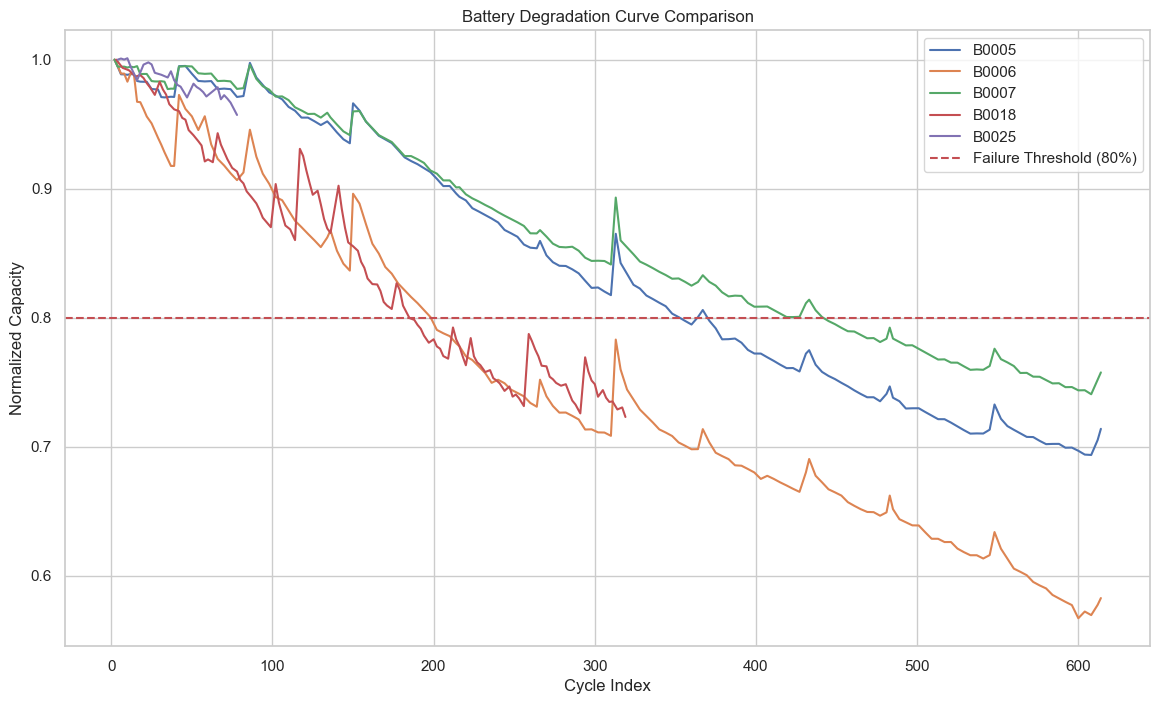

In [ ]:
# --- 6. Visualize Degradation Curves ---
plt.figure(figsize=(14, 8))

batteries_to_plot = df_battery['battery_id'].unique()[:5]  # plot first 5 batteries

for bat_id in batteries_to_plot:
    subset = df_battery[df_battery['battery_id'] == bat_id]
    plt.plot(subset['cycle_index'], subset['norm_capacity'], label=bat_id)

plt.axhline(y=0.8, color='r', linestyle='--', label='Failure Threshold (80%)')
plt.xlabel('Cycle Index')
plt.ylabel('Normalized Capacity')
plt.title('Battery Degradation Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- 7. Save Processed Data ---
output_path = '../data/processed/battery_degradation.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_battery.to_csv(output_path, index=False)

print(f"Data saved to {output_path}")

Data saved to ../data/processed/battery_degradation.csv
